In [30]:
## Long Short Term Memory (LSTM)

In [31]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Import necessary libraries
import re                                                                               # Regular expressions module used for cleaning and processing text
from tensorflow.keras.preprocessing.text import Tokenizer                               # To vectorize the text corpus by turning each word into an integer index
from tensorflow.keras.preprocessing.sequence import pad_sequences                       # Pads sequences to ensure they all have the same length
from tensorflow.keras.utils import to_categorical                                       # Converts class vectors (integers) to one-hot encoded vectors
import pickle                                                                           # Used for saving the tokenizer or other objects so they can be reused later
import numpy as np                                                                      # Fundamental library for numerical operations, particularly arrays
import time                                                                             # Used for time-related functions
import matplotlib.pyplot as plt                                                         # Used for plotting graphs like model accuracy and loss curves
from tensorflow.keras.models import Sequential                                          # Sequential model, where layers are stacked one on top of the other
from tensorflow.keras.layers import Dense, Embedding, LSTM, BatchNormalization, Dropout # Various building blocks for building deep learning models
from tensorflow.keras.optimizers import Adam, RMSprop                                   # Popular optimizers for training the model

In [33]:
# Open the text file for reading with UTF-8 encoding

file = open('LSTM DATA.txt', encoding='utf8')


In [34]:
# Read all lines from the file
lines = file.readlines()

In [35]:
# Close the file after reading the content
file.close()

In [36]:
# Join the list of lines into a single string (text corpus)
df = ' '.join(lines)

In [37]:
# Clean the text by removing unwanted characters such as newlines, carriage returns, and special quotation marks
df = df.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“', '').replace('”', '')

In [38]:
# Additional cleaning using regex to remove any remaining unwanted characters
df = re.sub(r'\ufeff', '', df)
df = re.sub(r'[“”"‘’]', '', df)

In [39]:
# Initialize the tokenizer
tokenizer = Tokenizer()


In [40]:
# Fit the tokenizer on the cleaned text (learn the word index from the text)
tokenizer.fit_on_texts([df])


In [41]:
# Check the size of the vocabulary (number of unique words)
print(len(tokenizer.word_index))

7172


In [55]:
# Save the tokenizer using pickle for future use
pickle.dump(tokenizer, open('token.pkl', 'wb'))

In [57]:
# Initialize an empty list to store the input sequences
input_sequences = []

# Tokenize each sentence, splitting the text based on periods ('.')
for sentence in df.split('. '):  # Split by sentence
    tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]  # Convert each sentence to a sequence of tokens

    # Create input sequences for each sentence by progressively increasing the token length
    for i in range(1, len(tokenized_sentence)):
        input_sequences.append(tokenized_sentence[:i+1])

In [59]:
# Find the maximum length of the input sequences
max_len = max([len(x) for x in input_sequences])
print(max_len)


152


In [61]:
# Pad the input sequences to make them of equal length (pre-padding with zeros)
padded_input_sequences = pad_sequences(input_sequences, maxlen=max_len, padding='pre')

# Separate the input sequences into features (x) and target labels (y)
x = padded_input_sequences[:, :-1]
y = padded_input_sequences[:, -1]

# One-hot encode the output labels (y) into categorical format
y = to_categorical(y, num_classes=7173)

In [63]:
# Print the shapes of x and y
print(x.shape)
print(y.shape)

(124648, 151)
(124648, 7173)


In [65]:
# Baseline Model for Comparison
def build_baseline_model():
    # Define the baseline model
    model = Sequential()

    # Add an Embedding layer to convert word indices into dense vector representations
    model.add(Embedding(input_dim=14268, output_dim = 100, input_shape=(151,)))

    # Add 3 stacked LSTM layers for learning temporal dependencies in the text
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))

    # Add BatchNormalization to normalize activations and help with faster training
    model.add(BatchNormalization())

    # Add Dense output layer with softmax activation for multi-class classification (predicting the next word)
    model.add(Dense(7173, activation='softmax'))

    # Compile the model with categorical crossentropy loss (since it's multi-class classification)
    # Adam optimizer is used for optimization and accuracy is tracked as a metric
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary to check the architecture
    model.summary()

    # Compile the model using an optimizer adam
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [67]:
# Fine-tuned Model
def build_optimized_model():
    # Define the optimized model with adjustments in hyperparameters
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=14268, output_dim=128, input_shape=(151,)))

    # LSTM layers with more units and Dropout for regularization
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.2))  # Dropout to prevent overfitting
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(256))

    # Batch Normalization
    # model.add(BatchNormalization())

    # Dense output layer
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(7173, activation='softmax'))

    model.summary()

    # Compile the model using an optimizer with a lower learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

    return model

In [69]:
# Train the baseline model for comparison
baseline_model = build_baseline_model()

baseline_history = baseline_model.fit(x, y, epochs=15, batch_size = 64)

C:\Users\Rajesh\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 151, 100)            │       1,426,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 151, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 151, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7173)                │         925,317 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,045 (10.43 MB)

 Trainable params: 2,732,789 (10.42 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 1504s 766ms/step - accuracy: 0.0545 - loss: 6.8861
Epoch 2/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 1749s 898ms/step - accuracy: 0.1234 - loss: 5.3929
Epoch 3/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 1813s 931ms/step - accuracy: 0.1483 - loss: 5.0520
Epoch 4/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 2431s 1s/step - accuracy: 0.1639 - loss: 4.7610
Epoch 5/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 3239s 2s/step - accuracy: 0.1823 - loss: 4.5058
Epoch 6/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 2293s 1s/step - accuracy: 0.1992 - loss: 4.2479
Epoch 7/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 1837s 943ms/step - accuracy: 0.2199 - loss: 3.9981
Epoch 8/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 1866s 935ms/step - accuracy: 0.2481 - loss: 3.7380
Epoch 9/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 1895s 972ms/step - accuracy: 0.2798 - loss: 3.4915
Epoch 10/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 1958s 972ms/step - accuracy: 0.3129 - loss: 3.2464
Epoch 11/15
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 1886s 953ms/step - accuracy: 0.3474

In [73]:
# Save the baseline model
baseline_model.save('baseline_model.keras')

In [75]:
# Evaluate on the training set
evaluation = baseline_model.evaluate(x, y)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

3896/3896 ━━━━━━━━━━━━━━━━━━━━ 536s 137ms/step - accuracy: 0.5779 - loss: 1.8116
Test Loss: 1.8956925868988037, Test Accuracy: 0.5564228892326355


In [83]:
# Function to predict the next words based on the input text and model

def predict_next_words(text, model, tokenizer, num_words=15, max_length=3):
    """
    Parameters:
    text (str): The input sentence where predictions should begin.
    model (Sequential): The pre-trained model used for next-word prediction.
    tokenizer (Tokenizer): The tokenizer used to tokenize the input text.
    num_words (int): Number of words to predict (default is 15).
    max_len (int): Maximum length of the input sequence (default is 3).

    Returns:
    str: The input sentence appended with the predicted words.
    """

    # Loop to predict the next `num_words` words
    for i in range(num_words):
        # Tokenize the current text
        token_text = tokenizer.texts_to_sequences([text])[0]

        # Pad the sequence to ensure it matches the model's input shape
        padded_token_text = pad_sequences([token_text], maxlen=max_len-1, padding='pre')

        # Predict the next word index
        pos = np.argmax(model.predict(padded_token_text))

        # Find the word corresponding to the predicted index
        for word, index in tokenizer.word_index.items():
            if index == pos:
                # Append the predicted word to the text
                text = text + " " + word
                print(text)  # Print the text after each prediction

                # Optional sleep to simulate delay (can be removed if not needed)
                time.sleep(2)
                break  # Stop the loop once the word is found

    return text

In [87]:
# Analyze the baseline model's performance in predicting the next word
text = "who are the objects"
text = predict_next_words(text, baseline_model, tokenizer, num_words=15, max_length=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
who are the objects of
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
who are the objects of both
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
who are the objects of both self
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
who are the objects of both self spreading
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
who are the objects of both self spreading between
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
who are the objects of both self spreading between any
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
who are the objects of both self spreading between any other
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
who are the objects of both self spreading between any other elegant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
who are the objects of both self spreading between any other elegant goodness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
who are the objects of both self spreading between any other elegant goodness and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
who are the objects of both self spreading between any oth

In [89]:
# Plotting model accuracy and loss
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.title(f'Model {metric}')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.show()

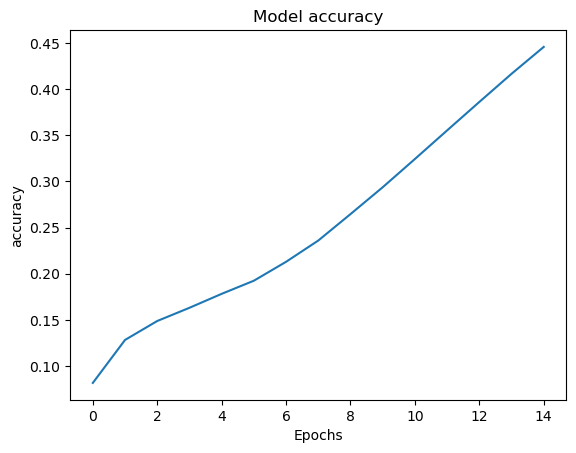

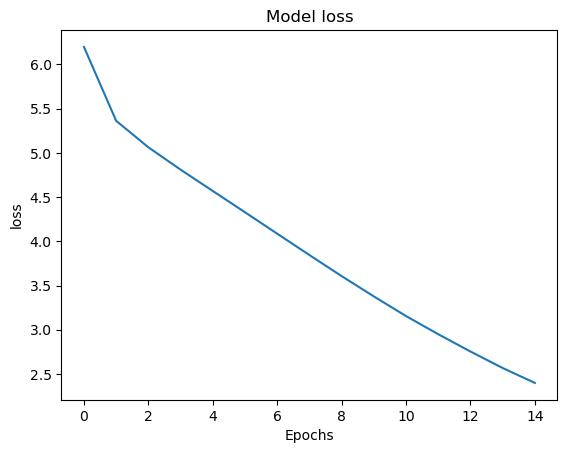

In [93]:
# Plot accuracy and loss graphs
plot_graphs(baseline_history, 'accuracy')
plot_graphs(baseline_history, 'loss')

In [95]:
# Train the optimized model
optimized_model = build_optimized_model()
optimized_history = optimized_model.fit(x, y, epochs=15, batch_size=128)  # Fine-tuned batch size

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 151, 128)            │       1,826,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 151, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 151, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 151, 256)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 151, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │         257,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7173)                │       7,180,173 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,708,341 (40.85 MB)

 Trainable params: 10,708,341 (40.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 7521s 8s/step - accuracy: 0.0392 - loss: 6.6186
Epoch 2/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 25225s 26s/step - accuracy: 0.0738 - loss: 5.9475
Epoch 3/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 6811s 7s/step - accuracy: 0.0995 - loss: 5.6036
Epoch 4/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 6394s 7s/step - accuracy: 0.1152 - loss: 5.3544
Epoch 5/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 8124s 8s/step - accuracy: 0.1223 - loss: 5.1930
Epoch 6/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 6020s 6s/step - accuracy: 0.1301 - loss: 5.0451
Epoch 7/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 15143s 16s/step - accuracy: 0.1362 - loss: 4.9035
Epoch 8/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 5222s 5s/step - accuracy: 0.1408 - loss: 4.7755
Epoch 9/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 8486s 9s/step - accuracy: 0.1443 - loss: 4.6519
Epoch 10/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 7472s 8s/step - accuracy: 0.1492 - loss: 4.5236
Epoch 11/15
974/974 ━━━━━━━━━━━━━━━━━━━━ 9180s 9s/step - accuracy: 0.1543 - loss: 4.3940
Epoch 12/15
974/974 ━━━━━━

In [97]:
# Save the fine-tuned model
optimized_model.save('optimized_model.keras')


In [99]:
# Evaluate both models on the training
baseline_evaluation = baseline_model.evaluate(x, y)
optimized_evaluation = optimized_model.evaluate(x, y)

print(f"Baseline Model - Loss: {baseline_evaluation[0]}, Accuracy: {baseline_evaluation[1]}")
print(f"Optimized Model - Loss: {optimized_evaluation[0]}, Accuracy: {optimized_evaluation[1]}")

3896/3896 ━━━━━━━━━━━━━━━━━━━━ 749s 192ms/step - accuracy: 0.5779 - loss: 1.8116
3896/3896 ━━━━━━━━━━━━━━━━━━━━ 2166s 555ms/step - accuracy: 0.2162 - loss: 3.6703
Baseline Model - Loss: 1.8956925868988037, Accuracy: 0.5564228892326355
Optimized Model - Loss: 3.6874194145202637, Accuracy: 0.20847506821155548


In [103]:
# Plotting model accuracy and loss
def plot_graphs(history, metric, title):
    plt.plot(history.history[metric])
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.show()

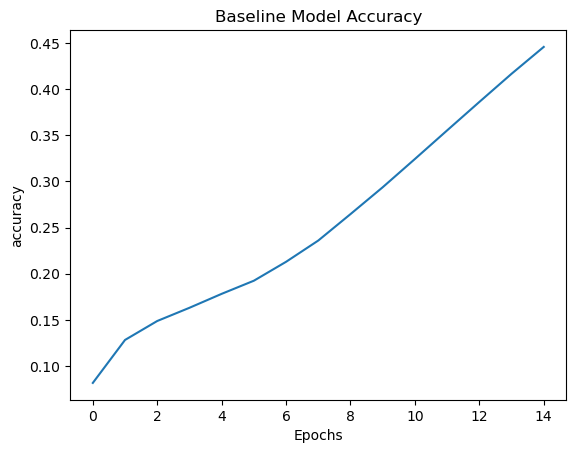

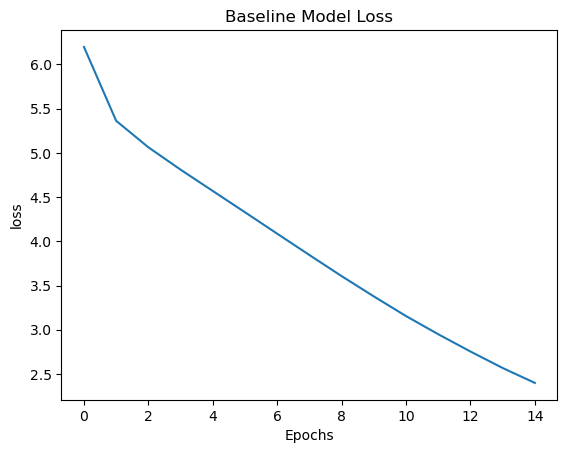

In [105]:
# Plot baseline model accuracy and loss
plot_graphs(baseline_history, 'accuracy', 'Baseline Model Accuracy')
plot_graphs(baseline_history, 'loss', 'Baseline Model Loss')

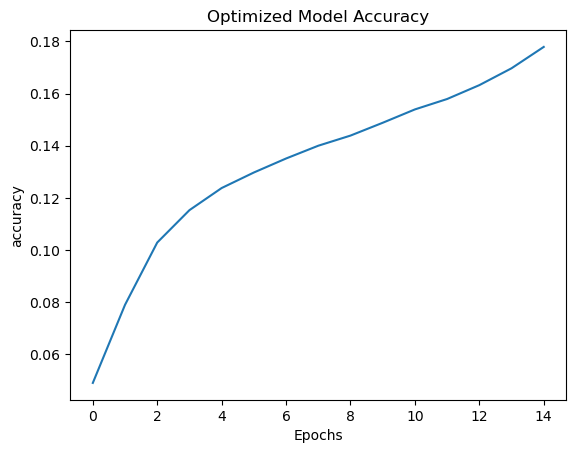

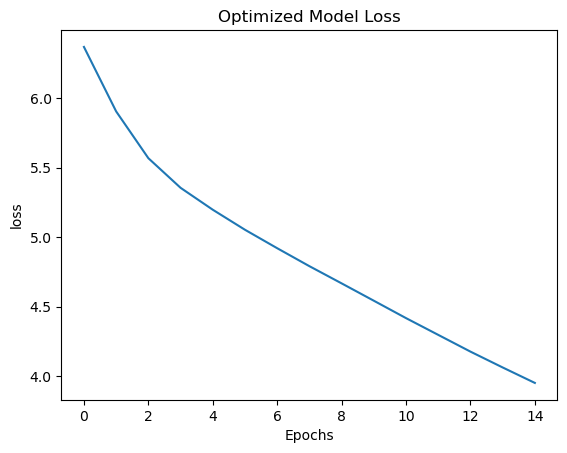

In [107]:
# Plot optimized model accuracy and loss
plot_graphs(optimized_history, 'accuracy', 'Optimized Model Accuracy')
plot_graphs(optimized_history, 'loss', 'Optimized Model Loss')

In [113]:
# Analyze the performance of the optimized model in generating words
text = "who are the objects"
text = predict_next_words(text, optimized_model, tokenizer, num_words=15, max_length=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
who are the objects of
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
who are the objects of the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
who are the objects of the world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
who are the objects of the world and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
who are the objects of the world and seek
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
who are the objects of the world and seek of
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
who are the objects of the world and seek of the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
who are the objects of the world and seek of the world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
who are the objects of the world and seek of the world and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
who are the objects of the world and seek of the world and seek
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
who are the objects of the world and seek of the world and seek compassion
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
who are the objects of the wor

In [115]:
# CONCLUSION: 
# Baseline Model - Loss: 1.8956925868988037, Accuracy: 0.5564228892326355
# Optimized Model - Loss: 3.6874194145202637, Accuracy: 0.20847506821155548
# Hence, its clearly evident that the baseline model is already better than the optimized model in terms of accuracy and loss